In [1]:
# Install packages required

import sys
!{sys.executable} -m pip install --user pandas matplotlib PyQt5 statsmodels pmdarima

In [2]:
# imports

import pandas as pd
import matplotlib.pyplot as plotter
import PyQt5
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pmda
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from pandas import datetime

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':


In [3]:
# Fetch & structure data from CSV file
RawData = pd.read_csv('../Data/solarpower_cumuldaybyday.csv', header=None)
RawData.columns = ['Date', 'Reading', 'Extra']
RawData.drop(columns=['Extra'], inplace=True)
RawData.head(5)

,Date,Reading
0,26/10/2011,0.1
1,27/10/2011,10.2
2,28/10/2011,20.2
3,29/10/2011,29.6
4,30/10/2011,34.2


In [4]:
# Set the date as index
RawData.set_index('Date', inplace=True)
RawData.head(5)

,Reading
Date,
26/10/2011,0.1
27/10/2011,10.2
28/10/2011,20.2
29/10/2011,29.6
30/10/2011,34.2


In [5]:
Data = RawData.reindex(pd.date_range(start=datetime(2011, 10, 27), periods=2470, freq='d'))
Data.Reading = RawData.Reading.values
Data.head(5)

,Reading
2011-10-27,0.1
2011-10-28,10.2
2011-10-29,20.2
2011-10-30,29.6
2011-10-31,34.2


In [6]:
# Convert 'Reading' values to numeric type & 'Date' values to datetime type  
Data.Reading = pd.to_numeric(Data.Reading)
Data.index = pd.to_datetime(Data.index)
Data.head(5)

,Reading
2011-10-27,0.1
2011-10-28,10.2
2011-10-29,20.2
2011-10-30,29.6
2011-10-31,34.2


In [7]:
# Compute Rolling Mean and Rolling Standard Deviation for the given data

rolmean = Data.rolling(window=30).mean()
rolmean.fillna(value=rolmean.mean(), inplace=True)
print(rolmean.tail(5))

print('\n')

rolstd = Data.rolling(window=30).std()
rolstd.fillna(value=rolstd.mean(), inplace=True)
print(rolstd.tail(5))

                 Reading
2018-07-27  26525.033333
2018-07-28  26547.833333
2018-07-29  26570.366667
2018-07-30  26592.933333
2018-07-31  26615.000000


               Reading
2018-07-27  196.832763
2018-07-28  194.732546
2018-07-29  192.553706
2018-07-30  190.830478
2018-07-31  189.031652


Text(0.5, 0.98, 'Daily Readings')

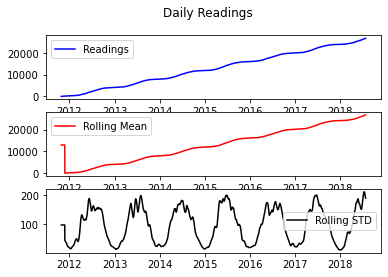

In [8]:
# Plotting data, mean, and standard deviation

# Uncomment the below line to open plots in a separate interactive window
# %matplotlib qt

# Uncomment the below line to open plots inline
%matplotlib inline

fig = plotter.figure()

ax1 = plotter.subplot2grid((3, 1), (0, 0))
ax2 = plotter.subplot2grid((3, 1), (1, 0), sharex=ax1)
ax3 = plotter.subplot2grid((3, 1), (2, 0), sharex=ax2)

ax1.plot(Data, color='blue', label='Readings')
ax2.plot(rolmean, color='red', label='Rolling Mean')
ax3.plot(rolstd, color='black', label='Rolling STD')

ax1.legend()
ax2.legend()
ax3.legend()

plotter.suptitle('Daily Readings')

In [9]:
# ADF Test for Stationarity for data, rolling mean, rolling standard deviation

# If the test statisic is less than the 10% critical value, 
# we can reject the null hypothesis and claim that the data 
# is stationary.

def ADFTest(data):
    result = adfuller(data.Reading)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print('Data\n----------')        
ADFTest(Data)

print('\n\nRolling Mean\n----------')  
ADFTest(rolmean)

print('\n\nRolling Standard Deviation\n----------')  
ADFTest(rolstd)

# As we can see after the test, the difference between the ADF Statistic
# and critical 10% value is highest for the original data as compared to 
# the Rolling Mean and Rolling Standard Deviation.

# Also, the original data has the lowest p-value as compared to the
# the Rolling Mean and Rolling Standard Deviation.

# This proves that the original data, used for prediction will yield best
# results. However, before concluding that, let us plot stationarity, 
# seasonality and trend for the data, rolling mean, and rolling standard 
# deviation.

Data
----------
ADF Statistic: 0.063082
p-value: 0.963448
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Rolling Mean
----------
ADF Statistic: 0.105557
p-value: 0.966438
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Rolling Standard Deviation
----------
ADF Statistic: -3.528006
p-value: 0.007296
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Text(0.5, 0.98, 'Actual Data')

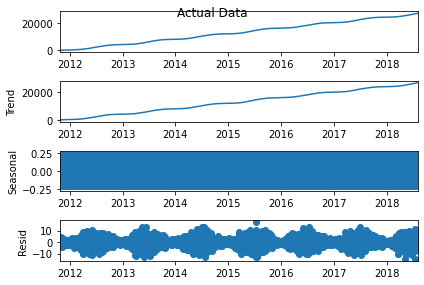

In [10]:
# plotting stationarity, seasonality, trend

# Uncomment the below line to open plots in a separate interactive window
# %matplotlib qt

# Uncomment the below line to open plots inline
%matplotlib inline

# Original Data
decomposition1 = sm.tsa.seasonal_decompose(Data, model='additive')
decomposition1.plot().suptitle('Actual Data')

Text(0.5, 0.98, 'Rolling Mean')

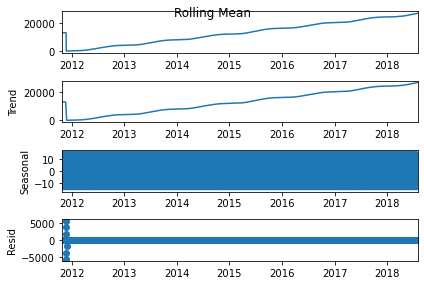

In [11]:
# Rolling Mean
decomposition2 = sm.tsa.seasonal_decompose(rolmean, model='additive')
decomposition2.plot().suptitle('Rolling Mean')

Text(0.5, 0.98, 'Rolling Standard Deviation')

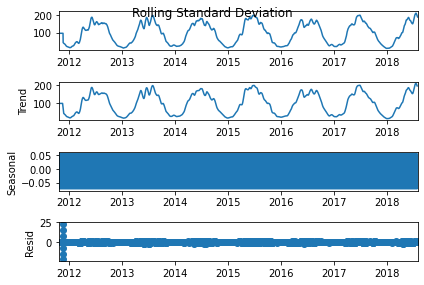

In [12]:
# Rolling Standard Deviation 
decomposition3 = sm.tsa.seasonal_decompose(rolstd, model='additive')
decomposition3.plot().suptitle('Rolling Standard Deviation')

In [13]:
# It is clearly evident from the plots that the original
# data has more stationary trend as compared to the 
# other two.

# Hence, we will now use the original data for predictions.

In [14]:
# Auto ARIMA to check AIC & BIC values for error rates (should be low)

stepwise_fit = pmda.auto_arima(Data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=14829.155, BIC=14858.189, Time=17.870 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=16499.042, BIC=16510.656, Time=0.155 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=15719.112, BIC=15742.338, Time=3.244 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=15586.536, BIC=15609.763, Time=3.723 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=16497.291, BIC=16503.098, Time=0.099 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=16219.034, BIC=16242.260, Time=1.007 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=14829.145, BIC=14863.985, Time=21.084 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=14831.914, BIC=14866.754, Time=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 2470
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -7378.159
Date:                              Wed, 01 Apr 2020   AIC                          14770.318
Time:                                      17:10:20   BIC                          14810.965
Sample:                                           0   HQIC                         14785.088
                                             - 2470                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.542      0.588      -0.000       0.001
ar.L1          1.2109      0.093     13.086      0.000       1.030       1.392
ar.L2         -0.2160      0.092     -2.360      0.018      -0.395      -0.037
ma.L1         -0.8785      0.094     -9.296      0.000      -1.064      -0.693
ma.L2          0.0107      0.076      0.142      0.887      -0.137       0.159
ma.S.L12      -0.9994      0.084    -11.868      0.000      -1.164      -0.834
sigma2        23.2388      1.940     11.980      0.000      19.437      27.041
===================================================================================
Ljung-Box (Q):                       50.90   Jarque-Bera (JB):                67.04
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# As you can see from the above output, the order of (2,1,2) generates 
# the lowest error rates. Thus, we will use this order while creating 
# our ARIMA model. Let us proceed.

# Train Model & Check Errors

Reading = Data.Reading
size = int(len(Reading) * 0.66)
train, test = Reading[0:size], Reading[size:len(Reading)]
history = [x for x in train]

predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)
print('\n\nMean Square Error: %.3f' % error)
print('Root Mean Square (RMS) Error: %.3f' % sqrt(error))
print('R Squared Score: %.3f' % r2_score(test, predictions))

predicted=16823.495582, expected=16822.000000
predicted=16834.763864, expected=16834.000000
predicted=16846.482179, expected=16847.000000
predicted=16859.753320, expected=16864.000000
predicted=16878.139222, expected=16881.000000
predicted=16895.466355, expected=16891.000000
predicted=16903.369128, expected=16915.000000
predicted=16931.893242, expected=16923.000000
predicted=16935.268737, expected=16946.000000
predicted=16962.773388, expected=16969.000000
predicted=16986.577587, expected=16992.000000
predicted=17010.274573, expected=17010.000000
predicted=17027.160169, expected=17025.000000
predicted=17041.210170, expected=17047.000000
predicted=17065.406192, expected=17054.000000
predicted=17067.751048, expected=17069.000000
predicted=17084.496691, expected=17082.000000
predicted=17096.744650, expected=17098.000000
predicted=17113.490461, expected=17110.000000
predicted=17124.194045, expected=17123.000000
predicted=17137.199337, expected=17150.000000
predicted=17168.730917, expected=1

predicted=19783.043302, expected=19778.000000
predicted=19785.505692, expected=19788.000000
predicted=19797.077069, expected=19798.000000
predicted=19807.252760, expected=19806.000000
predicted=19814.679868, expected=19813.000000
predicted=19821.250423, expected=19815.000000
predicted=19821.404327, expected=19825.000000
predicted=19833.538865, expected=19829.000000
predicted=19835.772174, expected=19840.000000
predicted=19848.755850, expected=19850.000000
predicted=19858.776985, expected=19859.000000
predicted=19867.598946, expected=19862.000000
predicted=19868.628608, expected=19865.000000
predicted=19871.140502, expected=19870.000000
predicted=19876.441103, expected=19879.000000
predicted=19886.650811, expected=19888.000000
predicted=19895.872342, expected=19891.000000
predicted=19897.004384, expected=19892.000000
predicted=19896.929243, expected=19895.000000
predicted=19900.122405, expected=19904.000000
predicted=19910.929033, expected=19907.000000
predicted=19912.221974, expected=1

predicted=20713.007906, expected=20716.000000
predicted=20731.578050, expected=20729.000000
predicted=20743.148721, expected=20741.000000
predicted=20754.607254, expected=20750.000000
predicted=20762.336425, expected=20773.000000
predicted=20789.685275, expected=20796.000000
predicted=20813.527534, expected=20811.000000
predicted=20826.445307, expected=20823.000000
predicted=20837.312104, expected=20835.000000
predicted=20848.979240, expected=20857.000000
predicted=20874.146654, expected=20866.000000
predicted=20879.284290, expected=20883.000000
predicted=20898.422857, expected=20899.000000
predicted=20914.273190, expected=20923.000000
predicted=20941.075091, expected=20943.000000
predicted=20960.459826, expected=20961.000000
predicted=20978.059215, expected=20987.000000
predicted=21006.885228, expected=20995.000000
predicted=21009.513495, expected=21010.000000
predicted=21025.943183, expected=21020.000000
predicted=21034.105689, expected=21038.000000
predicted=21054.236764, expected=2

predicted=23754.935724, expected=23751.000000
predicted=23761.017942, expected=23756.000000
predicted=23764.963444, expected=23765.000000
predicted=23774.791868, expected=23780.000000
predicted=23791.697195, expected=23787.000000
predicted=23796.455376, expected=23797.000000
predicted=23807.141885, expected=23808.000000
predicted=23818.459964, expected=23810.000000
predicted=23817.539733, expected=23815.000000
predicted=23822.838928, expected=23820.000000
predicted=23827.482697, expected=23825.000000
predicted=23832.176809, expected=23829.000000
predicted=23835.578060, expected=23841.000000
predicted=23849.934782, expected=23847.000000
predicted=23854.346766, expected=23856.000000
predicted=23864.187970, expected=23866.000000
predicted=23874.643173, expected=23875.000000
predicted=23883.499784, expected=23881.000000
predicted=23888.579206, expected=23887.000000
predicted=23894.391063, expected=23894.000000
predicted=23901.562091, expected=23898.000000
predicted=23904.509977, expected=2

predicted=24584.766393, expected=24579.000000
predicted=24586.811931, expected=24596.000000
predicted=24607.856842, expected=24604.000000
predicted=24613.512208, expected=24614.000000
predicted=24623.996115, expected=24621.000000
predicted=24630.002543, expected=24630.000000
predicted=24639.411140, expected=24641.000000
predicted=24651.019834, expected=24652.000000
predicted=24662.147421, expected=24664.000000
predicted=24674.591515, expected=24683.000000
predicted=24696.090977, expected=24702.000000
predicted=24715.852633, expected=24722.000000
predicted=24736.857719, expected=24730.000000
predicted=24741.514951, expected=24742.000000
predicted=24754.383532, expected=24748.000000
predicted=24758.319229, expected=24753.000000
predicted=24762.408782, expected=24763.000000
predicted=24773.499134, expected=24778.000000
predicted=24790.100134, expected=24790.000000
predicted=24801.473736, expected=24809.000000
predicted=24822.859533, expected=24834.000000
predicted=24850.529714, expected=2

                             ARIMA Model Results                              
Dep. Variable:              D.Reading   No. Observations:                 2469
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7383.824
Method:                       css-mle   S.D. of innovations              4.813
Date:                Wed, 01 Apr 2020   AIC                          14779.647
Time:                        17:20:09   BIC                          14814.517
Sample:                    10-28-2011   HQIC                         14792.315
                         - 07-31-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.1691      2.224      5.021      0.000       6.809      15.529
ar.L1.D.Reading     1.2273      0.162      7.573      0.000       0.910       1.545
ar.L2.D.Reading    -0.2326      

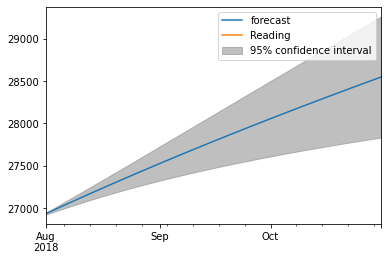

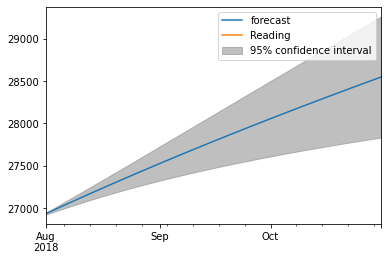

In [16]:
# Fit model & Plot Prediction

model = ARIMA(Reading, order=(2, 1, 2), freq='D')
model_fit = model.fit(disp=0)
print(model_fit.summary())

%matplotlib qt
# model_fit.plot_predict(datetime(2018, 8, 1), datetime(2018,10, 31))
model_fit.plot_predict(datetime(2018, 8, 1), datetime(2018,10, 31))

In [29]:
# Save Predictions

Predictions = model_fit.forecast(steps=92)[0]
df = pd.DataFrame(data={'Date': pd.date_range(start=datetime(2018, 8, 1), periods=92, freq='d'), 'Reading': Predictions})
df.to_csv('../Data/3MonthPredictedReadings.csv')
df.head(5)

,Date,Reading
0,2018-08-01,26938.778187
1,2018-08-02,26958.433826
2,2018-08-03,26978.248056
3,2018-08-04,26998.052785
4,2018-08-05,27017.808959
